# Difference-in-Differences Analysis for Cooling Interventions

This notebook implements DiD analysis to evaluate cooling interventions effectiveness.

## Data Preparation Steps:
1. Load and prepare master dataframe
2. Create treatment and control groups
3. Define pre and post intervention periods
4. Calculate necessary variables for DiD analysis

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from datetime import datetime, timedelta

# Load the master dataframe and logger flags
master_df = pd.read_csv('master_dataframe.csv', parse_dates=['DateTime'])
logger_flags_df = pd.read_csv('logger_flags.csv')

# Set DateTime as index
master_df = master_df.set_index('DateTime')

# Create dictionary for logger metadata
logger_metadata = logger_flags_df.set_index('Loggers').to_dict('index')

# Define intervention dates
rainbow_intervention_date = pd.to_datetime('2024-07-16')
sports_intervention_date = pd.to_datetime('2024-07-20')

# Display basic information
print('Master dataframe shape:', master_df.shape)
print('\nLogger flags shape:', logger_flags_df.shape)
print('\nLogger flags columns:', logger_flags_df.columns.tolist())

Master dataframe shape: (90832, 46)

Logger flags shape: (42, 9)

Logger flags columns: ['Loggers', 'Shaded', 'Unshaded', 'Settlement', 'Intervention', 'Logger_Type', 'Baseline_Start', 'Intervention_Start', 'Post_Intervention_End']


In [12]:
logger_flags_df.head()

,Loggers,Shaded,Unshaded,Settlement,Intervention,Logger_Type,Baseline_Start,Intervention_Start,Post_Intervention_End
0,R-01,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
1,R-02,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
2,R-04,True,False,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
3,R-05,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06
4,R-06,False,True,Sports Complex,CONTROL,R,2024-06-04,2024-07-20,2024-08-06


In [13]:
# Create treatment indicators
treatment_groups = {
    'RBF': logger_flags_df[logger_flags_df['Intervention'] == 'RBF']['Loggers'].tolist(),
    'MEB': logger_flags_df[logger_flags_df['Intervention'] == 'MEB']['Loggers'].tolist(),
    'Control': logger_flags_df[logger_flags_df['Intervention'] == 'CONTROL']['Loggers'].tolist()
}

# Create settlement indicators
settlements = {
    'Rainbow Field': logger_flags_df[logger_flags_df['Settlement'] == 'Rainbow Field']['Loggers'].tolist(),
    'Sports Complex': logger_flags_df[logger_flags_df['Settlement'] == 'Sports Complex']['Loggers'].tolist()
}

# Create shading indicators
shading = {
    'Shaded': logger_flags_df[logger_flags_df['Shaded'] == True]['Loggers'].tolist(),
    'Unshaded': logger_flags_df[logger_flags_df['Shaded'] == False]['Loggers'].tolist()
}

print("Number of loggers in each treatment group:")
for group, loggers in treatment_groups.items():
    print(f"{group}: {len(loggers)}")

print("\nNumber of loggers in each settlement:")
for settlement, loggers in settlements.items():
    print(f"{settlement}: {len(loggers)}")

print("\nNumber of loggers by shading:")
for shade, loggers in shading.items():
    print(f"{shade}: {len(loggers)}")

Number of loggers in each treatment group:
RBF: 15
MEB: 11
Control: 16

Number of loggers in each settlement:
Rainbow Field: 14
Sports Complex: 28

Number of loggers by shading:
Shaded: 19
Unshaded: 23


In [15]:
# Function to create DiD dataset for a specific logger
def prepare_logger_data(logger_id):
    # Get logger metadata
    metadata = logger_metadata[logger_id]
    
    # Get temperature data and align with environmental data
    temp_data = master_df[logger_id]
    env_temp = master_df['Env_Temperature']
    
    # Create DataFrame with aligned data
    data = pd.DataFrame({
        'Temperature': temp_data,
        'Env_Temperature': env_temp,
        'Temperature_Difference': temp_data - env_temp,
        'Logger': logger_id,
        'Settlement': metadata['Settlement'],
        'Shaded': metadata['Shaded'],
        'Treatment': metadata['Intervention'] in ['RBF', 'MEB'],
        'RBF': metadata['Intervention'] == 'RBF',
        'MEB': metadata['Intervention'] == 'MEB'
    })
    
    # Add time-based features using the index
    data['Hour'] = data.index.hour
    data['Date'] = data.index.date
    data['Daytime'] = (data['Hour'] >= 6) & (data['Hour'] < 19)
    
    # Add post-intervention indicator
    intervention_date = rainbow_intervention_date if metadata['Settlement'] == 'Rainbow Field' else sports_intervention_date
    data['Post'] = data.index >= intervention_date
    
    return data.dropna()  # Remove any rows with missing data

# Prepare data for all loggers
did_data = []
for logger in master_df.columns:
    if logger != 'Env_Temperature' and logger in logger_metadata:
        logger_data = prepare_logger_data(logger)
        did_data.append(logger_data)

# Combine all logger data
did_df = pd.concat(did_data)

# Create interaction terms
did_df['Post_Treatment'] = did_df['Post'] * did_df['Treatment']
did_df['Post_RBF'] = did_df['Post'] * did_df['RBF']
did_df['Post_MEB'] = did_df['Post'] * did_df['MEB']

# Display information about the prepared dataset
print("DiD dataset shape:", did_df.shape)
print("\nColumns:", did_df.columns.tolist())
print("\nSample of the prepared data:")
print(did_df.head())

# Basic checks
print("\nNumber of observations by treatment and period:")
print(did_df.groupby(['Treatment', 'Post']).size())

print("\nMissing values:")
print(did_df.isnull().sum())

C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_57140\741109265.py:45: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_Treatment'] = did_df['Post'] * did_df['Treatment']
C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_57140\741109265.py:46: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_RBF'] = did_df['Post'] * did_df['RBF']
C:\Users\user.DESKTOP-N5TDEG3\AppData\Local\Temp\ipykernel_57140\741109265.py:47: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  did_df['Post_MEB'] = did_df['Post'] * did_df['MEB']


DiD dataset shape: (2279880, 16)

Columns: ['Temperature', 'Env_Temperature', 'Temperature_Difference', 'Logger', 'Settlement', 'Shaded', 'Treatment', 'RBF', 'MEB', 'Hour', 'Date', 'Daytime', 'Post', 'Post_Treatment', 'Post_RBF', 'Post_MEB']

Sample of the prepared data:
                     Temperature  Env_Temperature  Temperature_Difference  \
DateTime                                                                    
2024-07-17 01:27:00        31.28        30.820000                0.460000   
2024-07-17 01:28:00        31.30        30.813333                0.486667   
2024-07-17 01:29:00        31.33        30.806667                0.523333   
2024-07-17 01:30:00        31.36        30.800000                0.560000   
2024-07-17 01:31:00        31.39        30.793333                0.596667   

                    Logger      Settlement  Shaded  Treatment    RBF    MEB  \
DateTime                                                                      
2024-07-17 01:27:00   R-01  Sp

In [19]:
did_df.to_csv('did_df.csv', index=True)

## Parallel Trends Analysis and Initial DiD Models

This section provides comprehensive visual analysis of parallel trends and treatment effects through:

### 1. Parallel Trends Visualization
- **Overall treatment effect**: Comparison between all treated and control units
- **Settlement-specific effects**: Separate analysis for Rainbow Field and Sports Complex  
- **Intervention-specific effects**: Distinct RBF and MEB treatment effects
- **Shading heterogeneity**: Effects by shaded vs unshaded structures

### 2. Statistical Analysis
- Basic DiD regression models with cluster-robust standard errors
- Heterogeneous treatment effects by settlement and structural characteristics
- Robustness checks and sensitivity analysis

The visualizations below use professional styling with:
- Consistent color palette for clear group identification
- 95% confidence intervals where appropriate
- Properly formatted dates and intervention markers
- Publication-ready figure quality

Daily data shape: (546, 10)
Date range: 2024-06-04 00:00:00 to 2024-08-06 00:00:00
Treatment types: ['RBF' 'MEB' 'Control']


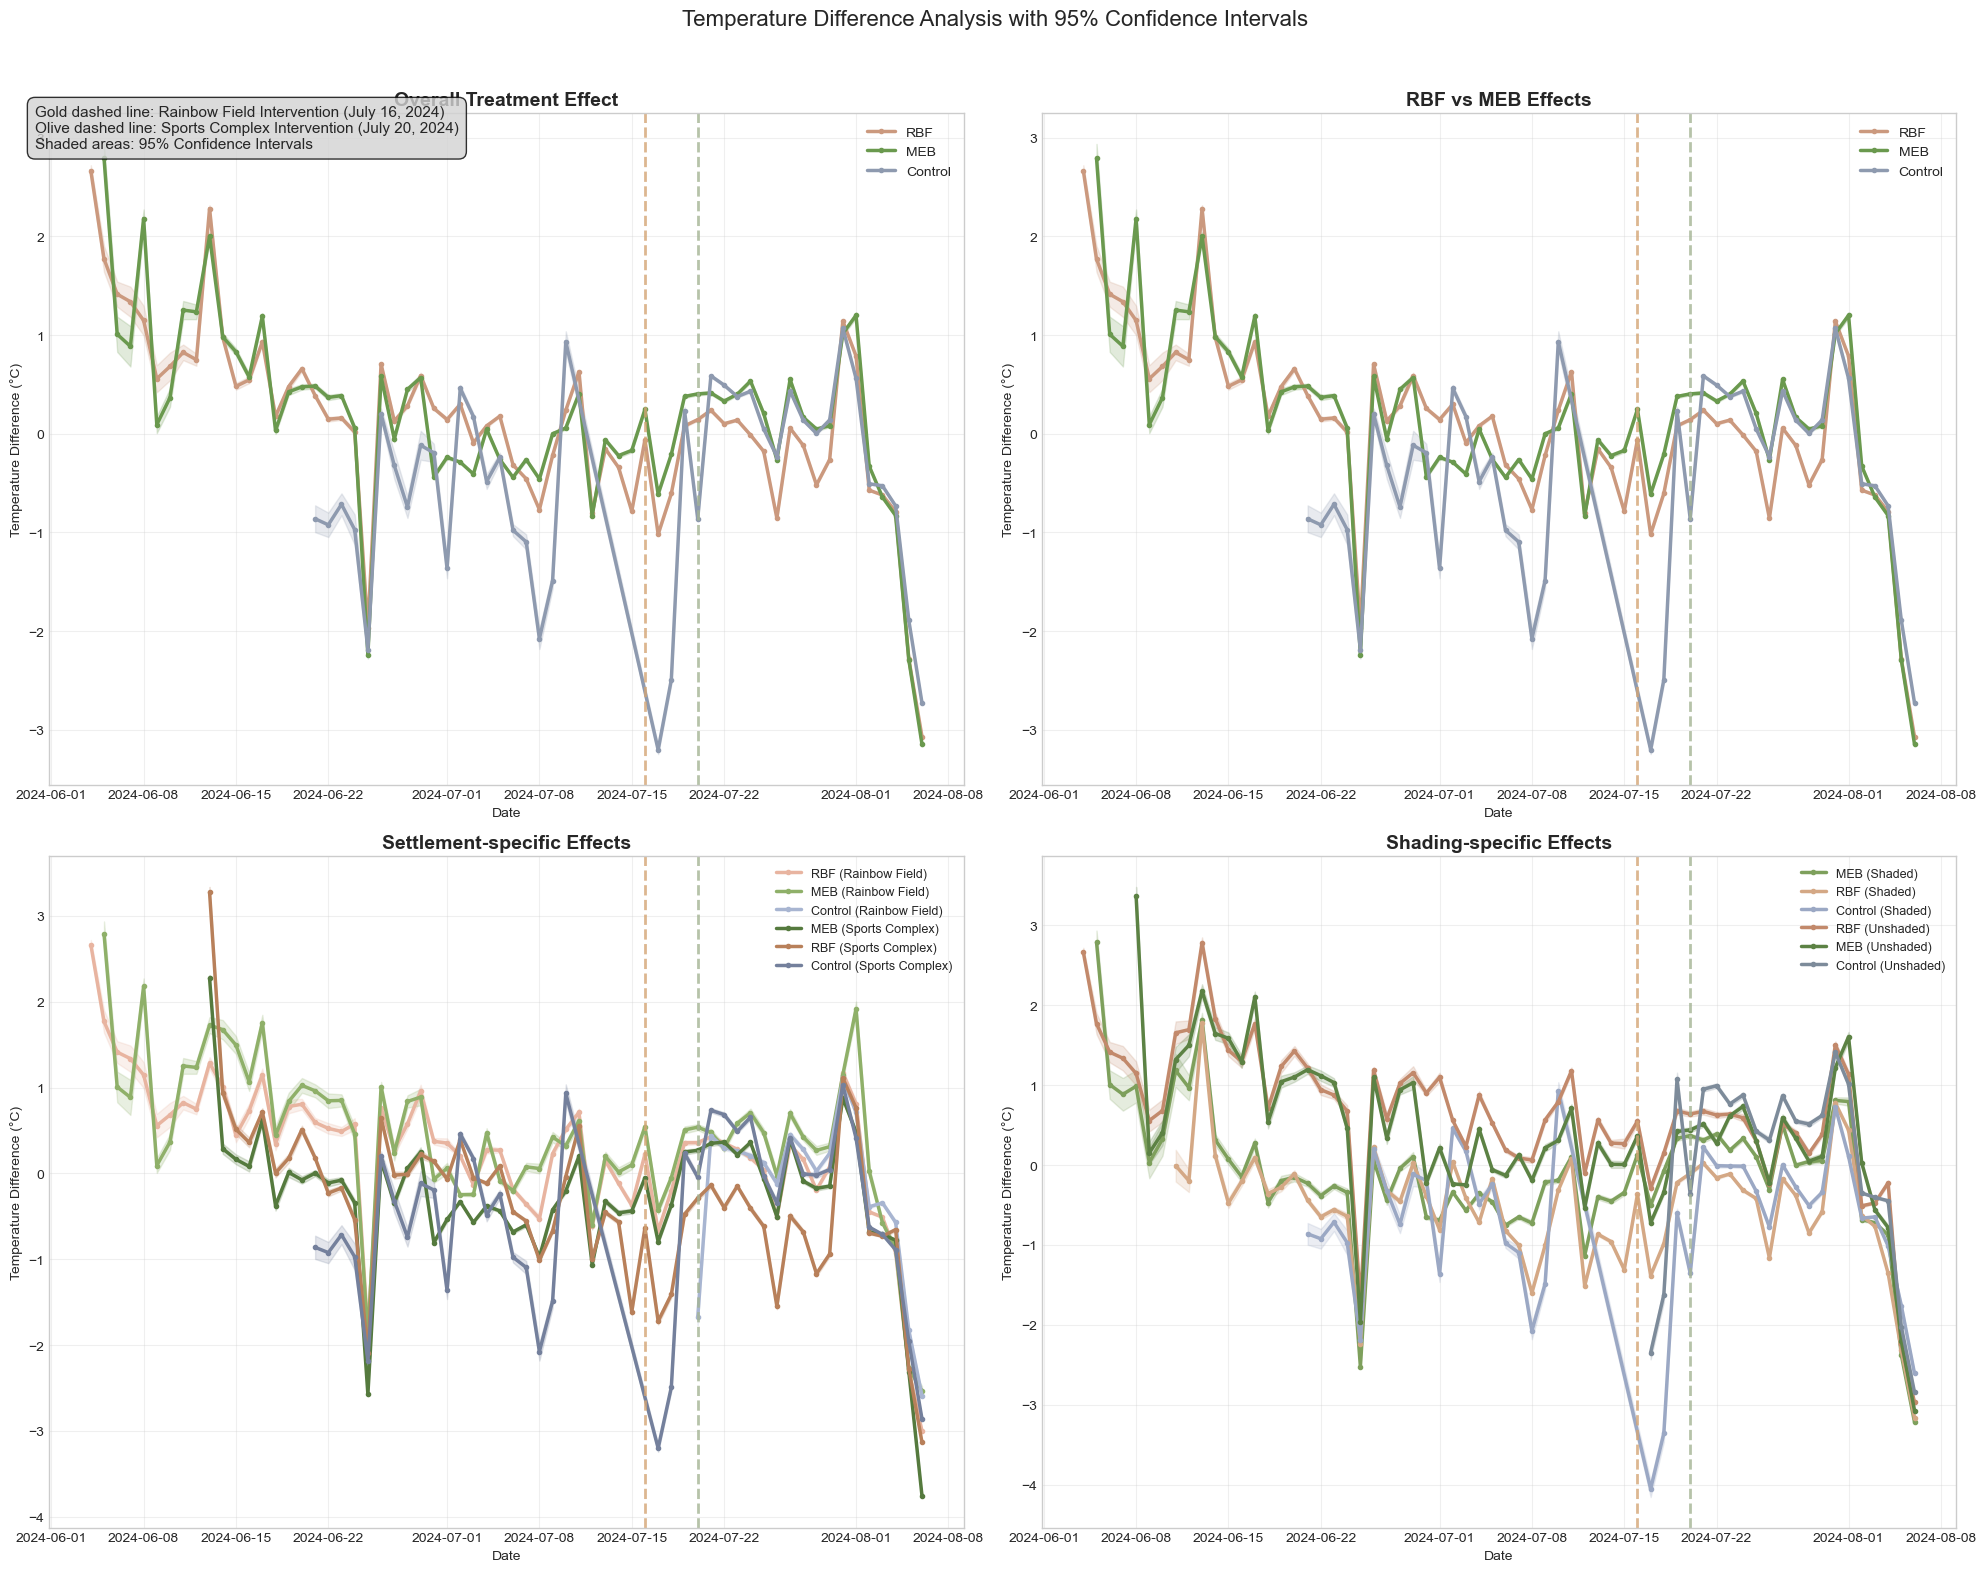


DATA VERIFICATION

Treatment assignment counts:
Treatment_Type
RBF        1037168
MEB         806099
Control     436613
Name: count, dtype: int64

Observations by settlement and treatment:
Treatment_Type  Control     MEB     RBF
Settlement                             
Rainbow Field    124557  267145  397503
Sports Complex   312056  538954  639665

Pre/Post period verification:
Post             False   True 
Treatment_Type                
Control          56834  379779
MEB             512579  293520
RBF             669738  367430

Intervention logic verification:
Rainbow Field: 391,273 pre, 397,932 post observations
Sports Complex: 847,878 pre, 642,797 post observations


In [38]:
# Parallel Trends Analysis with Confidence Intervals

# Convert Date to datetime for proper plotting
did_df['Date_dt'] = pd.to_datetime(did_df['Date'])

# Create treatment type variable
did_df['Treatment_Type'] = 'Control'
did_df.loc[did_df['RBF'] == True, 'Treatment_Type'] = 'RBF'
did_df.loc[did_df['MEB'] == True, 'Treatment_Type'] = 'MEB'

# Daily aggregation with confidence intervals
daily_avg = did_df.groupby(['Date_dt', 'Treatment_Type', 'Settlement', 'Shaded']).agg({
    'Temperature_Difference': ['mean', 'std', 'count']
}).reset_index()

# Flatten column names
daily_avg.columns = ['Date', 'Treatment_Type', 'Settlement', 'Shaded', 'Temp_Diff_Mean', 'Temp_Diff_Std', 'Count']

# Calculate 95% confidence intervals
daily_avg['SE'] = daily_avg['Temp_Diff_Std'] / np.sqrt(daily_avg['Count'])
daily_avg['CI_Lower'] = daily_avg['Temp_Diff_Mean'] - 1.96 * daily_avg['SE']
daily_avg['CI_Upper'] = daily_avg['Temp_Diff_Mean'] + 1.96 * daily_avg['SE']

print(f"Daily data shape: {daily_avg.shape}")
print(f"Date range: {daily_avg['Date'].min()} to {daily_avg['Date'].max()}")
print(f"Treatment types: {daily_avg['Treatment_Type'].unique()}")

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Define elegant pastel color scheme for better differentiation
colors = {
    'Control': '#8E9AAF',    # Sophisticated blue-gray
    'RBF': '#CB997E',        # Warm terracotta 
    'MEB': '#6A994E'         # Sage green
}

# Settlement-specific color variations (lighter/darker shades)
settlement_colors = {
    ('Control', 'Rainbow Field'): '#A8B5D1',     # Lighter blue-gray
    ('Control', 'Sports Complex'): '#74809C',     # Darker blue-gray
    ('RBF', 'Rainbow Field'): '#E8B4A0',         # Lighter terracotta
    ('RBF', 'Sports Complex'): '#B8805A',        # Darker terracotta  
    ('MEB', 'Rainbow Field'): '#8FB069',         # Lighter sage
    ('MEB', 'Sports Complex'): '#557A3E'         # Darker sage
}

# Shading-specific color variations  
shading_colors = {
    ('Control', 'Shaded'): '#9BA8C4',           # Muted blue-gray
    ('Control', 'Unshaded'): '#7D8B9A',         # Deeper blue-gray
    ('RBF', 'Shaded'): '#D4A885',              # Muted terracotta
    ('RBF', 'Unshaded'): '#C2896B',            # Deeper terracotta
    ('MEB', 'Shaded'): '#7EA05C',              # Muted sage
    ('MEB', 'Unshaded'): '#5C8244'             # Deeper sage
}

# Panel 1: Overall Treatment Effect
overall_data = daily_avg.groupby(['Date', 'Treatment_Type']).agg({
    'Temp_Diff_Mean': 'mean',
    'Count': 'sum',
    'Temp_Diff_Std': lambda x: np.sqrt(np.sum(x**2)) / len(x)
}).reset_index()

overall_data['SE'] = overall_data['Temp_Diff_Std'] / np.sqrt(overall_data['Count'])
overall_data['CI_Lower'] = overall_data['Temp_Diff_Mean'] - 1.96 * overall_data['SE']
overall_data['CI_Upper'] = overall_data['Temp_Diff_Mean'] + 1.96 * overall_data['SE']

for treatment in overall_data['Treatment_Type'].unique():
    data = overall_data[overall_data['Treatment_Type'] == treatment]
    ax1.plot(data['Date'], data['Temp_Diff_Mean'], 
            color=colors[treatment], linewidth=2.5, label=treatment, marker='o', markersize=3)
    ax1.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                    color=colors[treatment], alpha=0.2)

ax1.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax1.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax1.set_title('Overall Treatment Effect', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature Difference (°C)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: RBF vs MEB Effects
for treatment in overall_data['Treatment_Type'].unique():
    data = overall_data[overall_data['Treatment_Type'] == treatment]
    ax2.plot(data['Date'], data['Temp_Diff_Mean'], 
            color=colors[treatment], linewidth=2.5, label=treatment, marker='o', markersize=3)
    ax2.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                    color=colors[treatment], alpha=0.2)

ax2.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax2.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax2.set_title('RBF vs MEB Effects', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature Difference (°C)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Settlement-specific Effects
for settlement in ['Rainbow Field', 'Sports Complex']:
    settlement_data = daily_avg[daily_avg['Settlement'] == settlement]
    if not settlement_data.empty:
        settlement_summary = settlement_data.groupby(['Date', 'Treatment_Type']).agg({
            'Temp_Diff_Mean': 'mean',
            'Count': 'sum',
            'Temp_Diff_Std': lambda x: np.sqrt(np.sum(x**2)) / len(x)
        }).reset_index()
        
        settlement_summary['SE'] = settlement_summary['Temp_Diff_Std'] / np.sqrt(settlement_summary['Count'])
        settlement_summary['CI_Lower'] = settlement_summary['Temp_Diff_Mean'] - 1.96 * settlement_summary['SE']
        settlement_summary['CI_Upper'] = settlement_summary['Temp_Diff_Mean'] + 1.96 * settlement_summary['SE']
        
        for treatment in settlement_summary['Treatment_Type'].unique():
            data = settlement_summary[settlement_summary['Treatment_Type'] == treatment]
            color_key = (treatment, settlement)
            line_color = settlement_colors.get(color_key, colors[treatment])
            ax3.plot(data['Date'], data['Temp_Diff_Mean'], 
                    color=line_color, linestyle='-',
                    label=f'{treatment} ({settlement})', linewidth=2.5, marker='o', markersize=3)
            ax3.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                            color=line_color, alpha=0.2)

ax3.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax3.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax3.set_title('Settlement-specific Effects', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Temperature Difference (°C)')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Panel 4: Shading-specific Effects
for shaded in [True, False]:
    shade_label = 'Shaded' if shaded else 'Unshaded'
    shading_data = daily_avg[daily_avg['Shaded'] == shaded]
    if not shading_data.empty:
        shade_summary = shading_data.groupby(['Date', 'Treatment_Type']).agg({
            'Temp_Diff_Mean': 'mean',
            'Count': 'sum',
            'Temp_Diff_Std': lambda x: np.sqrt(np.sum(x**2)) / len(x)
        }).reset_index()
        
        shade_summary['SE'] = shade_summary['Temp_Diff_Std'] / np.sqrt(shade_summary['Count'])
        shade_summary['CI_Lower'] = shade_summary['Temp_Diff_Mean'] - 1.96 * shade_summary['SE']
        shade_summary['CI_Upper'] = shade_summary['Temp_Diff_Mean'] + 1.96 * shade_summary['SE']
        
        for treatment in shade_summary['Treatment_Type'].unique():
            data = shade_summary[shade_summary['Treatment_Type'] == treatment]
            color_key = (treatment, shade_label)
            line_color = shading_colors.get(color_key, colors[treatment])
            ax4.plot(data['Date'], data['Temp_Diff_Mean'], 
                    color=line_color, linestyle='-',
                    label=f'{treatment} ({shade_label})', linewidth=2.5, marker='o', markersize=3)
            ax4.fill_between(data['Date'], data['CI_Lower'], data['CI_Upper'],
                            color=line_color, alpha=0.2)

ax4.axvline(x=rainbow_intervention_date, color='#D4A574', linestyle='--', alpha=0.8, linewidth=2)  # Elegant gold
ax4.axvline(x=sports_intervention_date, color='#A4B494', linestyle='--', alpha=0.8, linewidth=2)   # Elegant olive
ax4.set_title('Shading-specific Effects', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Temperature Difference (°C)')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Add titles and legends
fig.suptitle('Temperature Difference Analysis with 95% Confidence Intervals', fontsize=16, y=0.98)

# Create intervention legend in upper portion to avoid x-axis overlap
legend_text = ('Gold dashed line: Rainbow Field Intervention (July 16, 2024)\n'
               'Olive dashed line: Sports Complex Intervention (July 20, 2024)\n'
               'Shaded areas: 95% Confidence Intervals')
fig.text(0.02, 0.92, legend_text, fontsize=11, verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Data verification and summary statistics
print("\n" + "="*60)
print("DATA VERIFICATION")
print("="*60)

print("\nTreatment assignment counts:")
print(did_df['Treatment_Type'].value_counts())

print("\nObservations by settlement and treatment:")
print(did_df.groupby(['Settlement', 'Treatment_Type']).size().unstack(fill_value=0))

print("\nPre/Post period verification:")
print(did_df.groupby(['Treatment_Type', 'Post']).size().unstack(fill_value=0))

print("\nIntervention logic verification:")
for settlement in ['Rainbow Field', 'Sports Complex']:
    intervention_date = rainbow_intervention_date if settlement == 'Rainbow Field' else sports_intervention_date
    settlement_data = did_df[did_df['Settlement'] == settlement]
    
    pre_count = settlement_data[settlement_data['Date_dt'] < intervention_date].shape[0]
    post_count = settlement_data[settlement_data['Date_dt'] >= intervention_date].shape[0]
    
    print(f"{settlement}: {pre_count:,} pre, {post_count:,} post observations")


# Difference-in-Differences Regression Models for Informal Settlements Cooling Study

Below are the mathematical formulations for each regression model in our analysis:

## 1. Basic DiD Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{Treatment}_i + \beta_3 (\text{Post}_t \times \text{Treatment}_i) + \varepsilon_{it}$$

Where:
- $Y_{it}$ is the temperature difference for unit $i$ at time $t$
- $\beta_0$ is the constant term (baseline temperature difference)
- $\text{Post}_t$ is a binary indicator equal to 1 for post-intervention period
- $\text{Treatment}_i$ is a binary indicator equal to 1 for treatment units
- $\text{Post}_t \times \text{Treatment}_i$ is the interaction term representing the DiD effect
- $\varepsilon_{it}$ is the error term
- $\beta_3$ is the causal effect of the intervention

## 2. Separate Interventions Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{RBF}_i + \beta_3 \text{MEB}_i + \beta_4 (\text{Post}_t \times \text{RBF}_i) + \beta_5 (\text{Post}_t \times \text{MEB}_i) + \varepsilon_{it}$$

Where:
- $\text{RBF}_i$ is a binary indicator equal to 1 for units treated with Radiant Barrier Foil
- $\text{MEB}_i$ is a binary indicator equal to 1 for units treated with Mylar Emergency Blankets
- $\beta_4$ is the causal effect of RBF intervention
- $\beta_5$ is the causal effect of MEB intervention

## 3. Controls Model

$$Y_{it} = \beta_0 + \beta_1 \text{Post}_t + \beta_2 \text{Treatment}_i + \beta_3 (\text{Post}_t \times \text{Treatment}_i) + \beta_4 \text{Shaded}_i + \beta_5 \text{Settlement}_i + \beta_6 \text{Daytime}_t + \varepsilon_{it}$$

Where:
- $\text{Shaded}_i$ is a binary indicator equal to 1 for shaded structures
- $\text{Settlement}_i$ is a categorical variable indicating the settlement type
- $\text{Daytime}_t$ is a binary indicator equal to 1 for daytime observations

## 4. Heterogeneous Effects Model

$$\begin{align}
Y_{it} = \beta_0 &+ \beta_1 \text{Post}_t + \beta_2 \text{Treatment}_i + \beta_3 (\text{Post}_t \times \text{Treatment}_i) \\
&+ \beta_4 \text{Shaded}_i + \beta_5 \text{Settlement}_i + \beta_6 \text{Daytime}_t \\
&+ \beta_7 (\text{Post}_t \times \text{Treatment}_i \times \text{Shaded}_i) \\
&+ \beta_8 (\text{Post}_t \times \text{Treatment}_i \times \text{Settlement}_i) \\
&+ \beta_9 (\text{Post}_t \times \text{Treatment}_i \times \text{Daytime}_t) + \varepsilon_{it}
\end{align}$$

Where:
- $\beta_7$ represents the differential effect of the intervention on shaded vs. unshaded structures
- $\beta_8$ represents the differential effect of the intervention between settlements
- $\beta_9$ represents the differential effect of the intervention during daytime vs. nighttime

## Variable Definitions

- **Temperature_Difference** ($Y_{it}$): The difference between indoor and outdoor temperatures (°C)
- **Post** ($\text{Post}_t$): Equal to 1 for observations after the intervention date, 0 otherwise
- **Treatment** ($\text{Treatment}_i$): Equal to 1 for structures receiving any intervention, 0 for control structures
- **RBF** ($\text{RBF}_i$): Equal to 1 for structures receiving Radiant Barrier Foil, 0 otherwise
- **MEB** ($\text{MEB}_i$): Equal to 1 for structures receiving Mylar Emergency Blankets, 0 otherwise
- **Shaded** ($\text{Shaded}_i$): Equal to 1 for structures with existing shade, 0 for unshaded structures
- **Settlement_num** ($\text{Settlement}_i$): Categorical variable identifying the settlement (Rainbow Field or Sports Complex)
- **Daytime** ($\text{Daytime}_t$): Equal to 1 for observations during daylight hours, 0 for nighttime observations

In [43]:
# Prepare data for regression analysis
print("Preparing regression data...")

# First, create a copy of the data for regression
regression_data = did_df.copy()

# Convert boolean columns to numeric
regression_data['Post'] = regression_data['Post'].astype(int)
regression_data['Treatment'] = regression_data['Treatment'].astype(int)
regression_data['Shaded'] = regression_data['Shaded'].astype(int)
regression_data['RBF'] = regression_data['RBF'].astype(int)
regression_data['MEB'] = regression_data['MEB'].astype(int)
regression_data['Daytime'] = regression_data['Daytime'].astype(int)

# Create numeric columns
regression_data['Settlement_num'] = (regression_data['Settlement'] == 'Sports Complex').astype(int)

# Ensure Temperature_Difference is numeric
regression_data['Temperature_Difference'] = pd.to_numeric(regression_data['Temperature_Difference'], errors='coerce')

# Create interaction terms
regression_data['Post_Treatment'] = regression_data['Post'] * regression_data['Treatment']
regression_data['Post_RBF'] = regression_data['Post'] * regression_data['RBF']
regression_data['Post_MEB'] = regression_data['Post'] * regression_data['MEB']
regression_data['Post_Treatment_Shaded'] = regression_data['Post_Treatment'] * regression_data['Shaded']
regression_data['Post_Treatment_Settlement'] = regression_data['Post_Treatment'] * regression_data['Settlement_num']
regression_data['Post_Treatment_Daytime'] = regression_data['Post_Treatment'] * regression_data['Daytime']

# Drop any rows with NaN values
regression_data = regression_data.dropna(subset=['Temperature_Difference'])

# Print data preparation summary
print("\nData preparation summary:")
print(f"Original observations: {len(did_df)}")
print(f"Observations after cleaning: {len(regression_data)}")
print("\nVariable statistics:")
print(regression_data[['Temperature_Difference', 'Post', 'Treatment', 'Post_Treatment']].describe())

# Dictionary to store regression results
models = {}

Preparing regression data...

Data preparation summary:
Original observations: 2279880
Observations after cleaning: 2279880

Variable statistics:
       Temperature_Difference          Post     Treatment  Post_Treatment
count            2.279880e+06  2.279880e+06  2.279880e+06    2.279880e+06
mean            -1.709633e-01  4.564841e-01  8.084930e-01    2.899056e-01
std              2.757393e+00  4.981029e-01  3.934872e-01    4.537185e-01
min             -1.210000e+01  0.000000e+00  0.000000e+00    0.000000e+00
25%             -1.700000e+00  0.000000e+00  1.000000e+00    0.000000e+00
50%             -2.000000e-01  0.000000e+00  1.000000e+00    0.000000e+00
75%              1.000000e+00  1.000000e+00  1.000000e+00    1.000000e+00
max              2.551833e+01  1.000000e+00  1.000000e+00    1.000000e+00


In [41]:

# CRITICAL VERIFICATION  Check Post assignment by Settlement and Treatment
print("\n" + "="*60)
print("CRITICAL VERIFICATION - Post Assignment Logic")
print("="*60)

# Check Post assignment by Settlement
print("\nPost assignment by Settlement:")
settlement_post = regression_data.groupby(['Settlement', 'Post']).size().unstack(fill_value=0)
print(settlement_post)
print(f"Rainbow Field Post %: {settlement_post.loc['Rainbow Field', 1] / settlement_post.loc['Rainbow Field'].sum() * 100:.1f}%")
print(f"Sports Complex Post %: {settlement_post.loc['Sports Complex', 1] / settlement_post.loc['Sports Complex'].sum() * 100:.1f}%")

# Check Post assignment by Treatment Type and Settlement
print("\nPost assignment by Treatment and Settlement:")
detailed_check = regression_data.groupby(['Settlement', 'Treatment_Type', 'Post']).size().unstack(fill_value=0)
print(detailed_check)

# Verify intervention date logic
print("\nIntervention date verification:")
print(f"Rainbow Field intervention: {rainbow_intervention_date}")
print(f"Sports Complex intervention: {sports_intervention_date}")

# Check actual date ranges for each settlement
for settlement in ['Rainbow Field', 'Sports Complex']:
    settlement_data = regression_data[regression_data['Settlement'] == settlement]
    pre_dates = settlement_data[settlement_data['Post'] == 0]['Date_dt']
    post_dates = settlement_data[settlement_data['Post'] == 1]['Date_dt']
    
    print(f"\n{settlement}:")
    print(f"  Pre-period: {pre_dates.min()} to {pre_dates.max()}")
    print(f"  Post-period: {post_dates.min()} to {post_dates.max()}")
    
    intervention_date = rainbow_intervention_date if settlement == 'Rainbow Field' else sports_intervention_date
    
    # Check if there are any post observations before intervention date
    wrong_post = settlement_data[(settlement_data['Post'] == 1) & (settlement_data['Date_dt'] < intervention_date)]
    # Check if there are any pre observations after intervention date
    wrong_pre = settlement_data[(settlement_data['Post'] == 0) & (settlement_data['Date_dt'] >= intervention_date)]
    
    print(f"  Wrong post assignments (post=1 before intervention): {len(wrong_post)}")
    print(f"  Wrong pre assignments (post=0 after intervention): {len(wrong_pre)}")

# Temperature difference verification by treatment
print(f"\n" + "="*60)
print("TEMPERATURE DIFFERENCE VERIFICATION")
print("="*60)
temp_by_treatment = regression_data.groupby(['Treatment_Type', 'Post'])['Temperature_Difference'].agg(['mean', 'std', 'count'])
print(temp_by_treatment.round(3))


CRITICAL VERIFICATION - Post Assignment Logic

Post assignment by Settlement:
Post                 0       1
Settlement                    
Rainbow Field   391273  397932
Sports Complex  847878  642797
Rainbow Field Post %: 50.4%
Sports Complex Post %: 43.1%

Post assignment by Treatment and Settlement:
Post                                0       1
Settlement     Treatment_Type                
Rainbow Field  Control              0  124557
               MEB             148813  118332
               RBF             242460  155043
Sports Complex Control          56834  255222
               MEB             363766  175188
               RBF             427278  212387

Intervention date verification:
Rainbow Field intervention: 2024-07-16 00:00:00
Sports Complex intervention: 2024-07-20 00:00:00

Rainbow Field:
  Pre-period: 2024-06-04 00:00:00 to 2024-07-15 00:00:00
  Post-period: 2024-07-16 00:00:00 to 2024-08-06 00:00:00
  Wrong post assignments (post=1 before intervention): 0
  Wrong 

In [ ]:

# CRITICAL VERIFICATION: Check Post assignment by Settlement and Treatment
print("\n" + "="*60)
print("CRITICAL VERIFICATION - Post Assignment Logic")
print("="*60)

# Check Post assignment by Settlement
print("\nPost assignment by Settlement:")
settlement_post = regression_data.groupby(['Settlement', 'Post']).size().unstack(fill_value=0)
print(settlement_post)
print(f"Rainbow Field Post %: {settlement_post.loc['Rainbow Field', 1] / settlement_post.loc['Rainbow Field'].sum() * 100:.1f}%")
print(f"Sports Complex Post %: {settlement_post.loc['Sports Complex', 1] / settlement_post.loc['Sports Complex'].sum() * 100:.1f}%")

# Check Post assignment by Treatment Type and Settlement
print("\nPost assignment by Treatment and Settlement:")
detailed_check = regression_data.groupby(['Settlement', 'Treatment_Type', 'Post']).size().unstack(fill_value=0)
print(detailed_check)

# Verify intervention date logic
print("\nIntervention date verification:")
print(f"Rainbow Field intervention: {rainbow_intervention_date}")
print(f"Sports Complex intervention: {sports_intervention_date}")

# Check actual date ranges for each settlement
for settlement in ['Rainbow Field', 'Sports Complex']:
    settlement_data = regression_data[regression_data['Settlement'] == settlement]
    pre_dates = settlement_data[settlement_data['Post'] == 0]['Date_dt']
    post_dates = settlement_data[settlement_data['Post'] == 1]['Date_dt']
    
    print(f"\n{settlement}:")
    print(f"  Pre-period: {pre_dates.min()} to {pre_dates.max()}")
    print(f"  Post-period: {post_dates.min()} to {post_dates.max()}")
    
    intervention_date = rainbow_intervention_date if settlement == 'Rainbow Field' else sports_intervention_date
    
    # Check if there are any post observations before intervention date
    wrong_post = settlement_data[(settlement_data['Post'] == 1) & (settlement_data['Date_dt'] < intervention_date)]
    # Check if there are any pre observations after intervention date
    wrong_pre = settlement_data[(settlement_data['Post'] == 0) & (settlement_data['Date_dt'] >= intervention_date)]
    
    print(f"  Wrong post assignments (post=1 before intervention): {len(wrong_post)}")
    print(f"  Wrong pre assignments (post=0 after intervention): {len(wrong_pre)}")

# Temperature difference verification by treatment
print(f"\n" + "="*60)
print("TEMPERATURE DIFFERENCE VERIFICATION")
print("="*60)
temp_by_treatment = regression_data.groupby(['Treatment_Type', 'Post'])['Temperature_Difference'].agg(['mean', 'std', 'count'])
print(temp_by_treatment.round(3))